In [2]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os
import sys

sns.set_style("white")
sns.set_palette("husl")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate


In [3]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        try:
            epoch = int(vals[1])
            num_backprop = int(vals[2])
            num_skipped = int(vals[3])
            loss = float(vals[5])
            time = float(vals[6])
            acc = float(vals[7])
            line_type = "train_debug"
        except:
            return None
    elif "test_debug" in line:
        try:
            epoch = int(vals[1])
            num_backprop = int(vals[2])
            num_skipped = int(vals[3])
            loss = float(vals[4])
            acc = float(vals[5])
            time = float(vals[6])
            line_type = "test_debug"
        except:
            return None
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [4]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                          self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, {}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        if self.seed:
            label += ", seed-{}".format(self.seed)
        else:
            label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * .90})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [5]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)
        print(config.label)
        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
 
        
    
    
    if len(ys_by_config.keys()) > 0:
        print("Sampling min:", config.top_k)
        print("Doing ", config.label)
        with open("/Users/angela/tmp/{}-{}-{}".format(ylabel, config.experiment_name, config.top_k), "w+") as f:
            for x, y in zip(xs, ys):
                line = "{},{}\n".format(x, y)
                f.write(line)
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
    
        format_plot(xlabel, ylabel)
        write_file(plot_prefix, show=True)




In [6]:
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop / 1000000. \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]

            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Aggregate Ratio Backpropped", plot_dir, smoothing, lw=3, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker)
    #plot(test_num_inferences_by_config, test_accuracies_by_config, "Num Images Forward Propped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [ ]:
## Comparison within CIFAR10 from epoch 1, 11, 81

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
experiment_base = "181205_multiverse"

plot_dir = "{}/{}/".format(plot_home_dir, experiment_base)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
do_plot = False
evaluate = True
epochs = [0, 10, 80]
    
experiment_names = ["{}_182818_losses_epoch{}".format(experiment_base, epoch) for epoch in epochs]

for experiment in experiment_names:
    if do_plot:
        plot_experiments([experiment],
                         experiment_dir,
                         plot_dir,
                         trials=[1],
                         ymin=0,
                         ymax=100)
    if evaluate:
        baseline_file = "deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2"
        Evaluate.evaluate(experiment_dir,
                          experiment,
                          baseline_file,
                          [experiment, experiment, experiment, experiment],
                          ["deterministic_cifar10_resnet_0.2_128_0.1_0.0005_trial1_seed1337_v2",
                           "deterministic_cifar10_resnet_0.4_128_0.1_0.0005_trial1_seed1337_v2",
                           "deterministic_cifar10_resnet_0.6_128_0.1_0.0005_trial1_seed1337_v2",
                           "deterministic_cifar10_resnet_0.8_128_0.1_0.0005_trial1_seed1337_v2"])

deterministic_cifar10_resnet_0.2_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.4_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.6_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.8_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.2, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 32 32
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.4, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 32 32
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.6, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.8, 128, lr=0.1, seed-

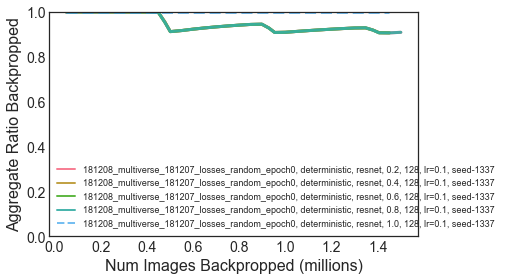

Num Images Backpropped (millions) , Test Accuracy 34 34
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.2, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.4, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.6, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 34 34
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.8, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 30 30
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337
('Sampling min:', 1.0)
('Doing ', '181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337')
../plots/181208_multiverse_181207_losses//181208_multiverse_181207_losses_random_epoch0_Num Ima

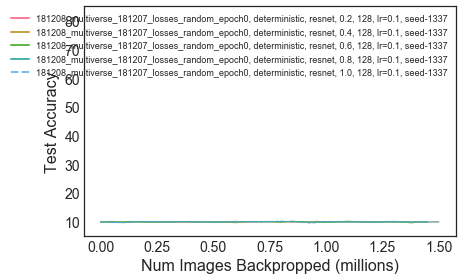

Num Images Backpropped (millions) , Test Loss 34 34
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.2, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.4, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 33 33
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.6, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 34 34
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 0.8, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 30 30
181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337
('Sampling min:', 1.0)
('Doing ', '181208_multiverse_181207_losses_random_epoch0, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337')
../plots/181208_multiverse_181207_losses//181208_multiverse_181207_losses_random_epoch0_Num Images Backpropped (mil

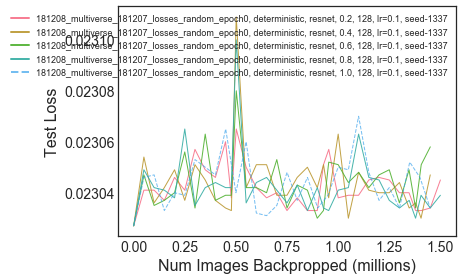

---------------181208_multiverse_181207_losses_random_epoch0-----------------
deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.2_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.42378177
deterministic_cifar10_resnet_0.4_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.466760125
deterministic_cifar10_resnet_0.6_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.43436912
deterministic_cifar10_resnet_0.8_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.422448045
deterministic_cifar10_resnet_0.2_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.4_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.6_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.8_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 34 34
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0

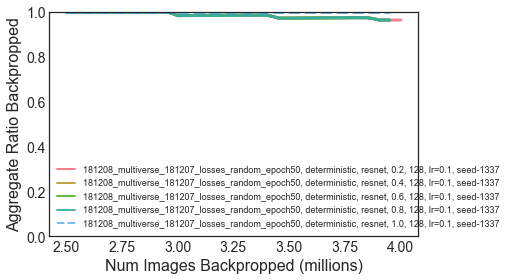

Num Images Backpropped (millions) , Test Accuracy 34 34
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.2, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.4, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.6, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.8, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Accuracy 30 30
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337
('Sampling min:', 1.0)
('Doing ', '181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337')
../plots/181208_multiverse_181207_losses//181208_multiverse_181207_losses_random_epoch50_

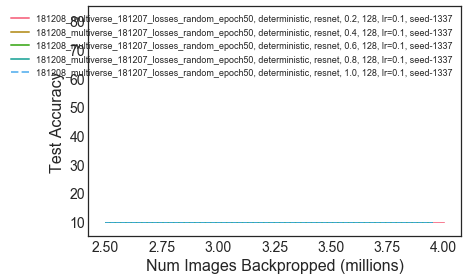

Num Images Backpropped (millions) , Test Loss 34 34
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.2, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.4, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.6, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 33 33
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 0.8, 128, lr=0.1, seed-1337
Num Images Backpropped (millions) , Test Loss 30 30
181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337
('Sampling min:', 1.0)
('Doing ', '181208_multiverse_181207_losses_random_epoch50, deterministic, resnet, 1.0, 128, lr=0.1, seed-1337')
../plots/181208_multiverse_181207_losses//181208_multiverse_181207_losses_random_epoch50_Num Images Backpropp

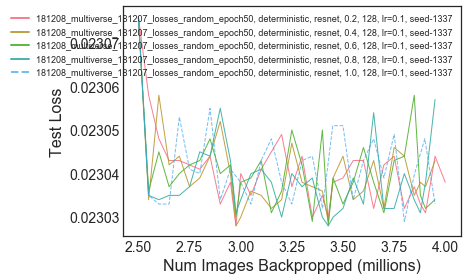

---------------181208_multiverse_181207_losses_random_epoch50-----------------
deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.2_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.46579
deterministic_cifar10_resnet_0.4_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: 0.49995
deterministic_cifar10_resnet_0.6_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: 0.49976
deterministic_cifar10_resnet_0.8_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: 0.49998


<Figure size 432x288 with 0 Axes>

In [10]:
## Comparison of CIFAR10 vs CIFAR10-Randomized from epoch 0

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
experiment_base = "181208_multiverse_181207_losses"

plot_dir = "{}/{}/".format(plot_home_dir, experiment_base)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
epochs = [0, 50]
    
experiment_names = ["{}_random_epoch{}".format(experiment_base, epoch) for epoch in epochs]
evaluate = True

for experiment in experiment_names:
    plot_experiments([experiment],
                         experiment_dir,
                         plot_dir,
                         trials=[1],
                         ymin=5,
                         ymax=85)
    if evaluate:
        print "---------------{}-----------------".format(experiment)
        baseline_file = "deterministic_cifar10_resnet_1_128_0.1_0.0005_trial1_seed1337_v2"
        Evaluate.evaluate_multiverse(experiment_dir,
                              experiment,
                              baseline_file,
                              experiment)

    

In [ ]:
## Multiverse of CIFAR10, epoch 0, 10, 150, 250

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
experiment_base = "181211_multiverse_181202_losses"
plot_dir = "{}/181211_multiverse/".format(plot_home_dir, experiment_base)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
do_plot = False
evaluate = True   

experiment_bases = ["181211_multiverse_181202_losses", "181211_multiverse_181209_losses"]
epochses = [[0, 10], [150, 250]]

for epochs, experiment_base in zip (epochses, experiment_bases):
 
    experiment_names = ["{}_epoch{}".format(experiment_base, epoch) for epoch in epochs]


    for experiment in experiment_names:
        if do_plot:
            plot_experiments([experiment],
                             experiment_dir,
                             plot_dir,
                             trials=[1],
                             ymin=0,
                             ymax=100)
        if evaluate:
            print "---------------{}-----------------".format(experiment)
            baseline_file = "deterministic_cifar10_resnet_1.0_128_0.1_0.0005_trial1_seed1337_v2"
            Evaluate.evaluate_multiverse(experiment_dir,
                              experiment,
                              baseline_file,
                              experiment)


topk_cifar10_resnet_102_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial2_seed1338_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial3_seed1339_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial4_seed1340_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial5_seed1341_v2
topk_cifar10_resnet_128_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_128_128_0.1_0.0005_trial2_seed1338_v2
topk_cifar10_resnet_128_128_0.1_0.0005_trial3_seed1339_v2
topk_cifar10_resnet_128_128_0.1_0.0005_trial4_seed1340_v2
topk_cifar10_resnet_128_128_0.1_0.0005_trial5_seed1341_v2
topk_cifar10_resnet_12_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_25_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_25_128_0.1_0.0005_trial2_seed1338_v2
topk_cifar10_resnet_25_128_0.1_0.0005_trial3_seed1339_v2
topk_cifar10_resnet_51_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_51_128_0.1_0.0005_trial2_seed1338_v2
topk_cifar10_resnet_51_128_0.1_0.0005_trial3_seed1339_v2
topk_cifar10_resnet_5

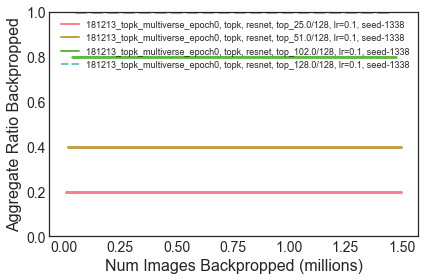

Num Images Backpropped (millions) , Test Accuracy 154 154
181213_topk_multiverse_epoch0, topk, resnet, top_25.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 76 76
181213_topk_multiverse_epoch0, topk, resnet, top_51.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 38 38
181213_topk_multiverse_epoch0, topk, resnet, top_102.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 30 30
181213_topk_multiverse_epoch0, topk, resnet, top_128.0/128, lr=0.1, seed-1338
('Sampling min:', 128.0)
('Doing ', '181213_topk_multiverse_epoch0, topk, resnet, top_128.0/128, lr=0.1, seed-1338')
../plots/181212_topk_multiverse//181213_topk_multiverse_epoch0_Num Images Backpropped (millions)_Test Accuracy_lr0.1.pdf


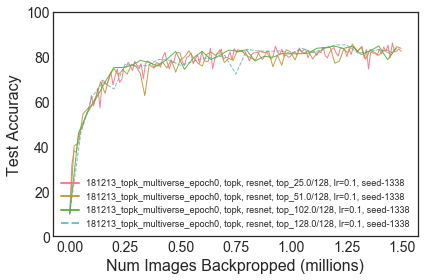

Num Images Backpropped (millions) , Test Loss 154 154
181213_topk_multiverse_epoch0, topk, resnet, top_25.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 76 76
181213_topk_multiverse_epoch0, topk, resnet, top_51.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 38 38
181213_topk_multiverse_epoch0, topk, resnet, top_102.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 30 30
181213_topk_multiverse_epoch0, topk, resnet, top_128.0/128, lr=0.1, seed-1338
('Sampling min:', 128.0)
('Doing ', '181213_topk_multiverse_epoch0, topk, resnet, top_128.0/128, lr=0.1, seed-1338')
../plots/181212_topk_multiverse//181213_topk_multiverse_epoch0_Num Images Backpropped (millions)_Test Loss_lr0.1.pdf


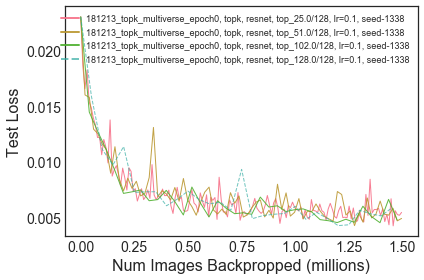

---------------181213_topk_multiverse_epoch0-----------------
topk_cifar10_resnet_128_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -0.31562712
topk_cifar10_resnet_102_128_0.1_0.0005_trial2_seed1338_v2
AUC Difference: 0.94892488
topk_cifar10_resnet_102_128_0.1_0.0005_trial3_seed1339_v2
AUC Difference: -0.07811352
topk_cifar10_resnet_102_128_0.1_0.0005_trial4_seed1340_v2
AUC Difference: 0.04647408
topk_cifar10_resnet_102_128_0.1_0.0005_trial5_seed1341_v2
AUC Difference: 0.21225372
topk_cifar10_resnet_128_128_0.1_0.0005_trial2_seed1338_v2
AUC Difference: 0.532
topk_cifar10_resnet_128_128_0.1_0.0005_trial3_seed1339_v2
AUC Difference: 1.56
topk_cifar10_resnet_128_128_0.1_0.0005_trial4_seed1340_v2
AUC Difference: 1.01125
topk_cifar10_resnet_128_128_0.1_0.0005_trial5_seed1341_v2
AUC Difference: 1.9695
topk_cifar10_resnet_12_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: 4.242942
topk_cifar10_resnet_25_128_0.1_0.0005_trial1_seed

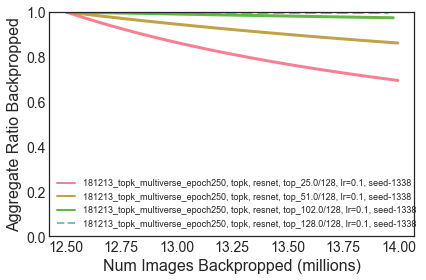

Num Images Backpropped (millions) , Test Accuracy 154 154
181213_topk_multiverse_epoch250, topk, resnet, top_25.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 76 76
181213_topk_multiverse_epoch250, topk, resnet, top_51.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 38 38
181213_topk_multiverse_epoch250, topk, resnet, top_102.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Accuracy 30 30
181213_topk_multiverse_epoch250, topk, resnet, top_128.0/128, lr=0.1, seed-1338
('Sampling min:', 128.0)
('Doing ', '181213_topk_multiverse_epoch250, topk, resnet, top_128.0/128, lr=0.1, seed-1338')
../plots/181212_topk_multiverse//181213_topk_multiverse_epoch250_Num Images Backpropped (millions)_Test Accuracy_lr0.1.pdf


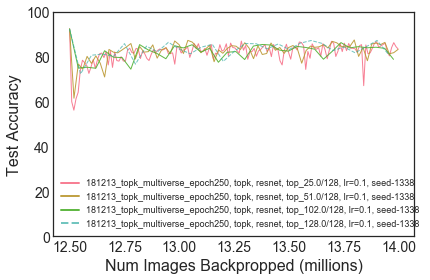

Num Images Backpropped (millions) , Test Loss 154 154
181213_topk_multiverse_epoch250, topk, resnet, top_25.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 76 76
181213_topk_multiverse_epoch250, topk, resnet, top_51.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 38 38
181213_topk_multiverse_epoch250, topk, resnet, top_102.0/128, lr=0.1, seed-1338
Num Images Backpropped (millions) , Test Loss 30 30
181213_topk_multiverse_epoch250, topk, resnet, top_128.0/128, lr=0.1, seed-1338
('Sampling min:', 128.0)
('Doing ', '181213_topk_multiverse_epoch250, topk, resnet, top_128.0/128, lr=0.1, seed-1338')
../plots/181212_topk_multiverse//181213_topk_multiverse_epoch250_Num Images Backpropped (millions)_Test Loss_lr0.1.pdf


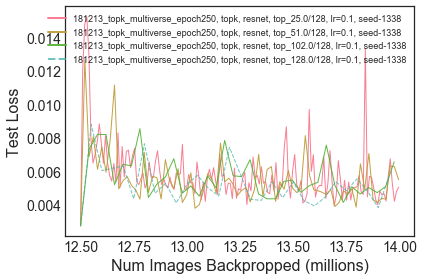

---------------181213_topk_multiverse_epoch250-----------------
topk_cifar10_resnet_128_128_0.1_0.0005_trial1_seed1337_v2
topk_cifar10_resnet_102_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: -1.44542132
topk_cifar10_resnet_102_128_0.1_0.0005_trial2_seed1338_v2
AUC Difference: -0.99243972
topk_cifar10_resnet_102_128_0.1_0.0005_trial3_seed1339_v2
AUC Difference: -1.04686916
topk_cifar10_resnet_102_128_0.1_0.0005_trial4_seed1340_v2
AUC Difference: -0.74504004
topk_cifar10_resnet_102_128_0.1_0.0005_trial5_seed1341_v2
AUC Difference: -0.20963144
topk_cifar10_resnet_128_128_0.1_0.0005_trial2_seed1338_v2
AUC Difference: 1.94425
topk_cifar10_resnet_128_128_0.1_0.0005_trial3_seed1339_v2
AUC Difference: 1.53775
topk_cifar10_resnet_128_128_0.1_0.0005_trial4_seed1340_v2
AUC Difference: -0.08325
topk_cifar10_resnet_128_128_0.1_0.0005_trial5_seed1341_v2
AUC Difference: 0.4595
topk_cifar10_resnet_12_128_0.1_0.0005_trial1_seed1337_v2
AUC Difference: 0.25024384
topk_cifar10_resnet_25_128_0.1_0.000

<Figure size 432x288 with 0 Axes>

In [22]:
## Multiverse of CIFAR10, epoch 0, 10, 150, 250

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
experiment_base = "181212_topk_multiverse"
plot_dir = "{}/181212_topk_multiverse/".format(plot_home_dir, experiment_base)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
do_plot = True
evaluate = True   

experiment_bases = ["181213_topk_multiverse"]
epochses = [[0, 250]]

for epochs, experiment_base in zip (epochses, experiment_bases):
 
    experiment_names = ["{}_epoch{}".format(experiment_base, epoch) for epoch in epochs]

    for experiment in experiment_names:
        if do_plot:
            plot_experiments([experiment],
                             experiment_dir,
                             plot_dir,
                             trials=[2],
                             ymin=0,
                             ymax=100)
        if evaluate:
            print "---------------{}-----------------".format(experiment)
            baseline_file = "topk_cifar10_resnet_128_128_0.1_0.0005_trial1_seed1337_v2"
            Evaluate.evaluate_multiverse(experiment_dir,
                              experiment,
                              baseline_file,
                              experiment)